In [115]:
#Yun-Ya, Huang    49343827

In [117]:
#Use this cell to import all the required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [119]:
#your work should only start with the following code
df=pd.read_excel("Assignment_Data.xlsx")

#### <font color="red"> When you are preparing your assignment, you can use as many cells and write any codes as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

In the Data Exploration, firstly, remove the "price_outcome = Equal", because those values cannot be used to predict whether the property can sell higher or lower. Next, remove the days_on_market entries with negative values and days_on_market > 500, because we are only interested in how fast the property can sell in the market without including those that cannot sell. Then, use the median of property_size to fill those missing values to minimize the effect of extreme values. The next step is to use visualization to quickly look at the distribution of data. It is obvious to see there are more higher price outcome properties compared to lower ones, and in the distribution of listed price and days_on_market, the former price is between 0 to 2 million, while the latter is from 0 to 200 days. Apart from that, most properties that sell at the best price have 4 bedrooms, 3 bathrooms, 3 parking spaces, and around 600 in property size, respectively. In the property classification, there is a higher proportion of higher price outcomes in houses and units. However, there is a higher proportion of lower price outcomes in penthouses and specialist farms from property_sub_classification.

Basic Information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6957 entries, 0 to 6956
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   property_address             6957 non-null   object        
 1   property_suburb              6957 non-null   object        
 2   property_state               6957 non-null   object        
 3   listing_description          6957 non-null   object        
 4   listed_date                  6957 non-null   datetime64[ns]
 5   listed_price                 6957 non-null   int64         
 6   days_on_market               6957 non-null   int64         
 7   number_of_beds               6957 non-null   int64         
 8   number_of_baths              6794 non-null   float64       
 9   number_of_parks              6766 non-null   float64       
 10  property_size                5050 non-null   float64       
 11  property_classification 

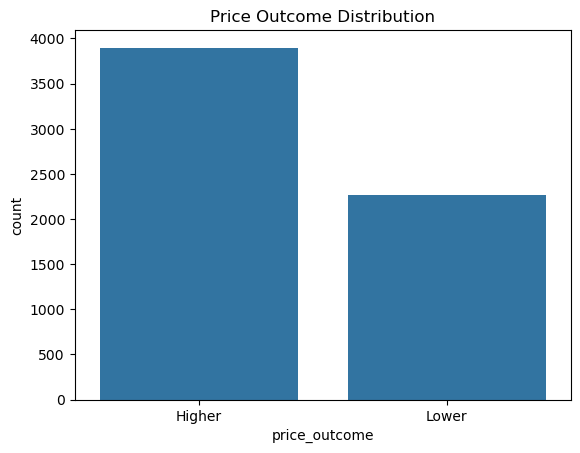

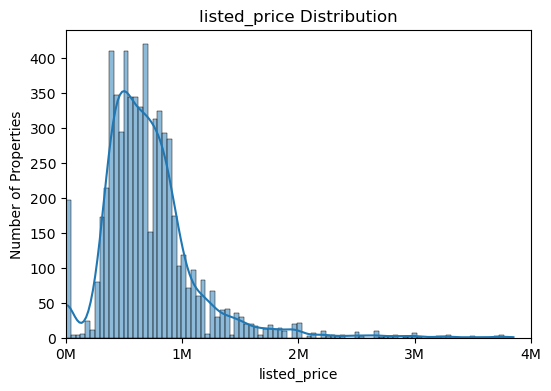

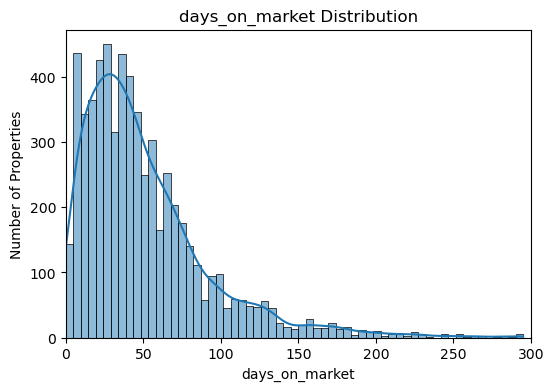

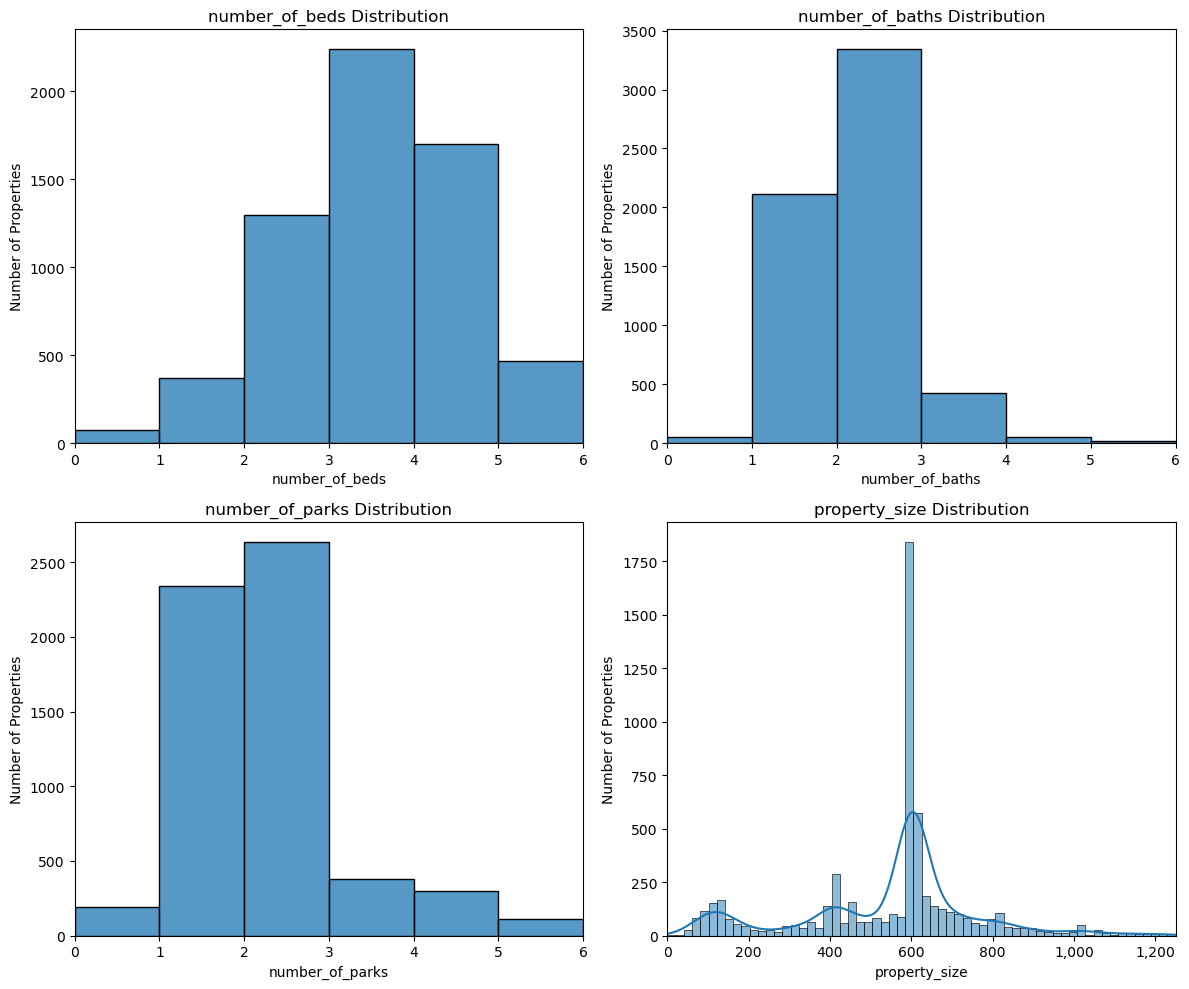

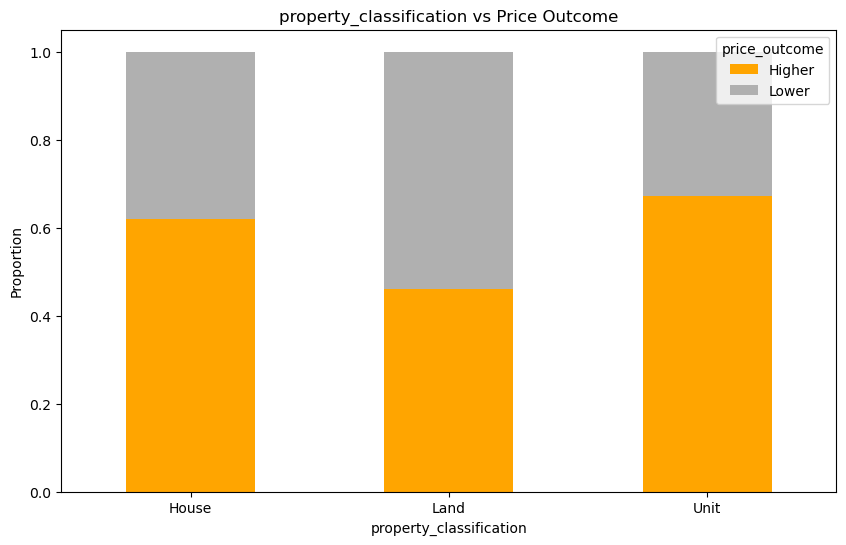

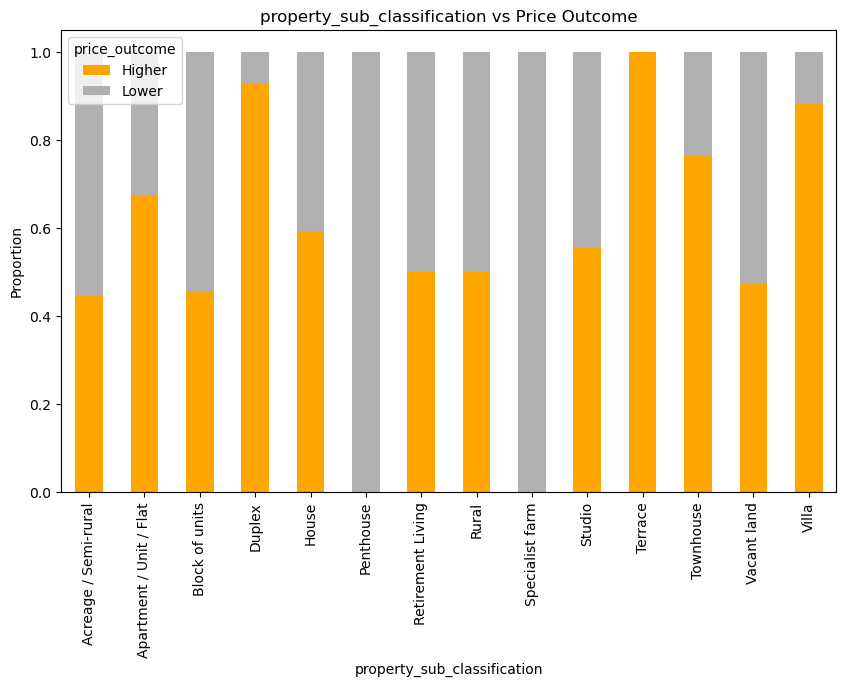

In [123]:
# Check basic data information
print("Basic Information：")
print(df.info())

# Check the distribution of the target variable
print("\nDistribution of target variable 'price_outcome':")
print(df['price_outcome'].value_counts())

# Remove rows where price_outcome == 'Equal' since we are doing binary classification only
df = df[df['price_outcome'] != 'Equal']
print("\nNumber of records remaining after removing 'Equal':", df.shape[0])

# Check missing values in numerical columns
num_cols = [ 'listed_price', 'days_on_market', 'number_of_beds', 
    'number_of_baths', 'number_of_parks', 'property_size',
    'suburb_days_on_market', 'suburb_median_price']
print("\nMissing value summary for numerical columns:")
print(df[num_cols].isna().sum())

# Fill missing values in property_size using the median (more robust against outliers)
if df['property_size'].isna().sum() > 0:
    median_size = df['property_size'].median()
    df['property_size'] = df['property_size'].fillna(median_size)
    print(f"\nFilled missing values in property_size with median value {median_size}.")

# Check how many rows have negative values in days_on_market
num_negative = df[df['days_on_market'] < 0].shape[0]
print(f"Number of rows where days_on_market < 0: {num_negative}")

# Remove rows with negative days_on_market values
df = df[df['days_on_market'] >= 0]
print(f"Number of rows after removing negative days_on_market: {df.shape[0]}")

# Check the maximum value of days_on_market
max_days = df['days_on_market'].max()
print(f"Maximum value of days_on_market: {max_days}")

# Remove extreme values (for example, days_on_market > 500)
df = df[df['days_on_market'] <= 500]
print(f"Number of rows after removing days_on_market > 500: {df.shape[0]}")

# Check the distribution of the price_outcome variable

sns.countplot(x=df['price_outcome'])
plt.title('Price Outcome Distribution')
plt.show()

# First handle listed_price and days_on_market (single plots)
x_limits_main = {'listed_price': (0, 4_000_000), 'days_on_market': (0, 300)}

for col in ['listed_price', 'days_on_market']:
    plt.figure(figsize=(6, 4))
    lower, upper = x_limits_main[col]
    filtered_data = df[df[col] <= upper][col]

    sns.histplot(filtered_data, kde=True)
    plt.title(f'{col} Distribution')
    plt.xlim(lower, upper)
    plt.ylabel('Number of Properties')
    ax = plt.gca()

    if col == 'listed_price':
        # Show major ticks every 1M, display as 0M, 1M, 2M, ...
        ax.xaxis.set_major_locator(mtick.MultipleLocator(1_000_000))
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
    else:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    plt.show()

# Then plot number_of_beds, number_of_baths, number_of_parks, property_size (in multi-subplot)
cols = ['number_of_beds', 'number_of_baths', 'number_of_parks', 'property_size']
x_limits = {'number_of_beds': (0, 6), 'number_of_baths': (0, 6), 'number_of_parks': (0, 6), 'property_size': (0, 1250)}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 subplots

for ax, col in zip(axes.flatten(), cols):
    lower, upper = x_limits[col]
    filtered_data = df[df[col] <= upper][col]

    if col in ['number_of_beds', 'number_of_baths', 'number_of_parks']:
        sns.histplot(filtered_data, kde=False, binwidth=1, ax=ax)
    else:
        sns.histplot(filtered_data, kde=True, ax=ax)

    ax.set_title(f'{col} Distribution')
    ax.set_xlim(lower, upper)
    ax.set_ylabel('Number of Properties')

    if col == 'property_size':
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    else:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.tight_layout()
plt.show()

category_cols = ['property_classification', 'property_sub_classification']
colors = {'Higher': '#FFA500',  # Bright orange
          'Lower': '#B0B0B0'}   # Grey

for col in category_cols:
    prop_df = (df.groupby([col, 'price_outcome']).size()
                 .groupby(level=0).apply(lambda x: x / x.sum())
                 .unstack())

    # Directly take the first level of multi-index as a plain index
    prop_df.index = prop_df.index.get_level_values(0)

    prop_df[['Higher', 'Lower']].plot(kind='bar', stacked=True, color=[colors['Higher'], colors['Lower']], figsize=(10, 6))
    plt.title(f'{col} vs Price Outcome')
    plt.ylabel('Proportion')

    if col == 'property_sub_classification':
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=0)

    plt.show()





# Text preparation

In the Text preparation, prepare the text for analysis by using NLTK to clean the listing descriptions by removing noise and stopwords. Next, apply sentiment analysis to capture emotional tones that might correlate with higher or lower price outcomes by scoring each description. However, when visualizing those efforts, it cannot show significant differences among outcomes. In the boxplot, it seems that both higher and lower price outcomes are close to 1, and they almost have the same distributions without difference. Therefore, decide to generate new features and build models which help to analyze the data more clearly.


100%|██████████| 6169/6169 [00:26<00:00, 232.42it/s]


                                  listing_description  description_sentiment
1   Poised To Impress This immaculate residence wi...                 0.9464
2   Affordable & Stylish This welcoming 4 Bedroom ...                 0.9924
3   FULLY RENOVATED LOW SET FAMILY HOME This stunn...                 0.9863
4   Renovated family home on 607sqm in leafy sough...                 0.9951
5   Charming Colonial Cottage This beautifully pre...                 0.9758
6   Character + Potential in the Heart of Wynnum -...                 0.9825
7   Huge Dual-Living Family Home in Private Elevat...                 0.9871
8   QUIET LOCATION - IMMACULATE FAMILY HOMEA super...                 0.9899
10  Rare Tropical Aspect\nRare Tropical Aspect. St...                 0.9678
11  Just A Few Minute's Walk To Goodna Railway Sta...                 0.9974
12  A Hidden Gem Welcome to 9 Boolungal Way. Are y...                 0.9265
13  UNDER CONTRACT Situated in the sought after Co...                 0.9456

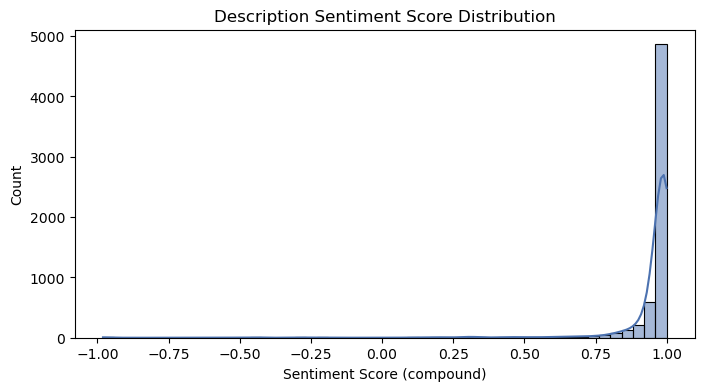

C:\Users\user\AppData\Local\Temp\ipykernel_4328\1434536820.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


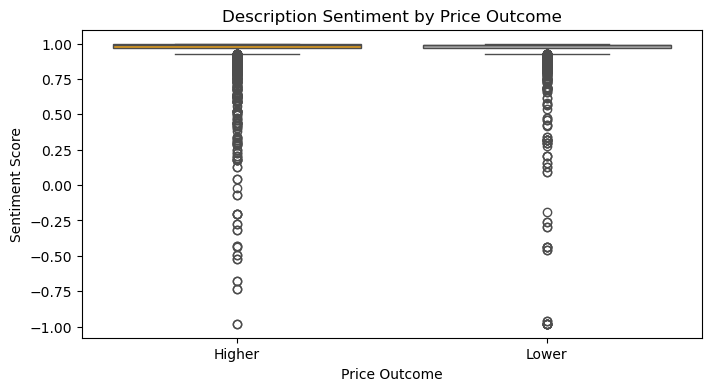

In [127]:
# Load NLTK text processing tools, including tokenizer, stopwords list, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation (keep letters and numbers)
    tokens = word_tokenize(text)  # Tokenize (split into words)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords like is, the, and
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization: e.g., words → word, running → run
    return ' '.join(tokens)

# This adds a new column 'cleaned_description' in the DataFrame to store the cleaned text
df['cleaned_description'] = df['listing_description'].apply(clean_text)

# description_word_count → how many words are in the description
df['description_word_count'] = df['listing_description'].apply(lambda x: len(str(x).split()))

# description_char_count → how many characters are in the description
df['description_char_count'] = df['listing_description'].apply(lambda x: len(str(x)))

# description_avg_word_length → average length of words in the description
df['description_avg_word_length'] = df['listing_description'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Enable plain-text progress bar (terminal style)
tqdm.pandas()

# Fill missing values to avoid analyzer errors
df['listing_description'] = df['listing_description'].fillna('')
# Add sentiment scores and display progress bar
df['description_sentiment'] = df['listing_description'].progress_apply(lambda x: sia.polarity_scores(str(x))['compound'])
print(df[['listing_description', 'description_sentiment']].iloc[1:50])

# 1. Overall sentiment score distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['description_sentiment'], bins=50, kde=True, color='#4C72B0')
plt.title('Description Sentiment Score Distribution')
plt.xlabel('Sentiment Score (compound)')
plt.ylabel('Count')
plt.show()

# 2. Sentiment score boxplot by price outcome
plt.figure(figsize=(8, 4))
sns.boxplot(
    x='price_outcome', 
    y='description_sentiment', 
    data=df, 
    palette={'Higher':'#FFA500', 'Lower':'#B0B0B0'}
)
plt.title('Description Sentiment by Price Outcome')
plt.xlabel('Price Outcome')
plt.ylabel('Sentiment Score')
plt.show()



# Feature generation

Beyond original variables, generated three new features: Price Ratio, Hot Suburb Flag, and Listing Month. Price Ratio helps compare listed price and market price. Calculation of Price Ratio is listed_price / suburb_median_price_filled to show the proportion of properties' price among the suburb median price, and it assists to see if the property is higher or lower than the market price.
Hot Suburb Flag helps to find where it is easy to sell at a higher price, using 1 as hot suburb and 0 as not hot suburb. The last one is Listing Month; it helps to analyze which months properties can sell at a higher price and whether it is influenced by seasons.

Apart from that, filled missing suburb median prices by median values per property type and cleaned extreme values carefully by keeping only the central 98%.

In the visualizations, it is obvious to see properties sell at higher prices from May to September.


##### Feature "Price Ratio" generation

✅ Completed median fill per property_classification for suburb_median_price
✅ Cleaned dataset: 5972 / 6169 rows retained after removing extreme low prices and high suburb medians
✅ Added feature: price_ratio (listed_price / suburb_median_price_filled)


C:\Users\user\AppData\Local\Temp\ipykernel_4328\3738323863.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_ratio'] = df_clean['listed_price'] / df_clean['suburb_median_price_filled']


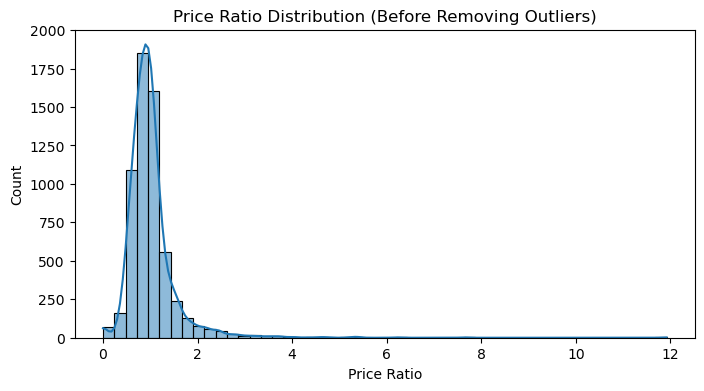

✅ Removed price_ratio outliers: kept rows between 0.1111 and 3.0216 → 5853 / 5972 rows retained


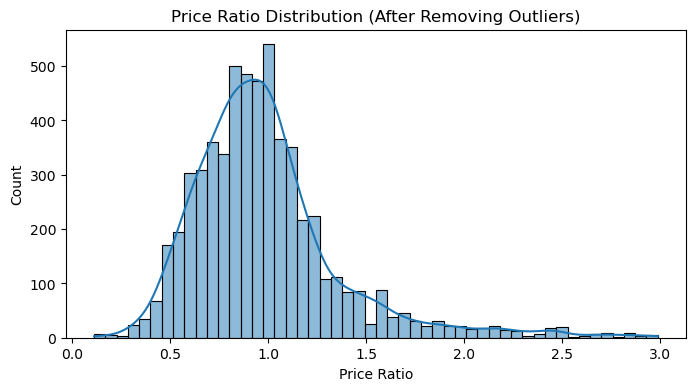

In [137]:
#Impute missing values: fill suburb_median_price using median within each property_classification group

df['suburb_median_price_filled'] = df.groupby('property_classification')['suburb_median_price'].transform(
    lambda x: x.fillna(x.median())
)
print("✅ Completed median fill per property_classification for suburb_median_price")

#Filter unreasonable values
high_median_cap = df['suburb_median_price_filled'].quantile(0.99)
df_clean = df[(df['listed_price'] > 100) & (df['suburb_median_price_filled'] <= high_median_cap)]
print(f"✅ Cleaned dataset: {df_clean.shape[0]} / {df.shape[0]} rows retained after removing extreme low prices and high suburb medians")

#Feature 1: Price Ratio
df_clean['price_ratio'] = df_clean['listed_price'] / df_clean['suburb_median_price_filled']
print("✅ Added feature: price_ratio (listed_price / suburb_median_price_filled)")

#Plot distribution before removing outliers
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['price_ratio'], bins=50, kde=True)
plt.title('Price Ratio Distribution (Before Removing Outliers)')
plt.xlabel('Price Ratio')
plt.ylabel('Count')
plt.show()

#Remove price_ratio outliers (keep only within 1% ~ 99% range)
lower_bound = df_clean['price_ratio'].quantile(0.01)
upper_bound = df_clean['price_ratio'].quantile(0.99)
original_count = df_clean.shape[0]

df_filtered = df_clean[(df_clean['price_ratio'] >= lower_bound) & (df_clean['price_ratio'] <= upper_bound)]
new_count = df_filtered.shape[0]
print(f"✅ Removed price_ratio outliers: kept rows between {lower_bound:.4f} and {upper_bound:.4f} → {new_count} / {original_count} rows retained")

#Plot distribution after removing outliers
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered['price_ratio'], bins=50, kde=True)
plt.title('Price Ratio Distribution (After Removing Outliers)')
plt.xlabel('Price Ratio')
plt.ylabel('Count')
plt.show()


##### Feature Hot Suburb Flag generation

In [140]:
#Feature 2: Hot Suburb Flag
# Create a flag feature: if suburb_days_on_market is less than the overall mean, mark as 1 (hot), otherwise 0 (not hot)
suburb_days_mean = df_filtered['suburb_days_on_market'].mean()
df_filtered['hot_suburb_flag'] = df_filtered['suburb_days_on_market'].apply(lambda x: 1 if pd.notnull(x) and x < suburb_days_mean else 0)
print(f"✅ Added feature: hot_suburb_flag (1 if suburb_days_on_market < {suburb_days_mean:.2f}, else 0)")


✅ Added feature: hot_suburb_flag (1 if suburb_days_on_market < 37.92, else 0)


C:\Users\user\AppData\Local\Temp\ipykernel_4328\2201114510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hot_suburb_flag'] = df_filtered['suburb_days_on_market'].apply(lambda x: 1 if pd.notnull(x) and x < suburb_days_mean else 0)


##### Feature listing_month generation

In [143]:
#Feature 3: Listing Month
# Extract the month part from listed_date to capture possible seasonal effects
df_filtered['listing_month'] = pd.to_datetime(df_filtered['listed_date']).dt.month
print("✅ Added feature: listing_month (extracted from listed_date)")


✅ Added feature: listing_month (extracted from listed_date)


C:\Users\user\AppData\Local\Temp\ipykernel_4328\4204162805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['listing_month'] = pd.to_datetime(df_filtered['listed_date']).dt.month


   listed_price  suburb_median_price  suburb_median_price_filled  price_ratio  \
0        475000                  NaN                    495000.0     0.959596   
1        899000                  NaN                    805000.0     1.116770   
2        579000                  NaN                    805000.0     0.719255   
3        800000                  NaN                    805000.0     0.993789   
4        889000             913000.0                    913000.0     0.973713   

   suburb_days_on_market  hot_suburb_flag listed_date  listing_month  
0                    NaN                0  2022-03-24              3  
1                    NaN                0  2022-06-16              6  
2                    NaN                0  2022-10-13             10  
3                    NaN                0  2022-07-31              7  
4                   28.0                1  2022-10-13             10  


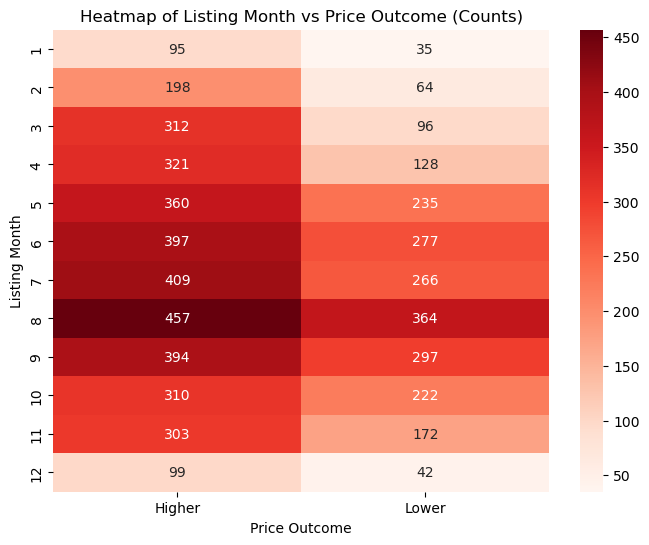

In [145]:
#Check the first few rows of new features
print(df_filtered[['listed_price', 'suburb_median_price', 'suburb_median_price_filled',
                   'price_ratio', 'suburb_days_on_market', 'hot_suburb_flag', 'listed_date', 'listing_month']].head())
# Listing Month × Price Outcome → 成交筆數熱力圖
month_outcome = pd.crosstab(df_filtered['listing_month'], df_filtered['price_outcome'])
plt.figure(figsize=(8, 6))
sns.heatmap(month_outcome, annot=True, cmap='Reds', fmt='d')
plt.title('Heatmap of Listing Month vs Price Outcome (Counts)')
plt.ylabel('Listing Month')
plt.xlabel('Price Outcome')
plt.show()



# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

In the model building stage, Random Forest was selected as the primary model due to its robustness, ability to handle mixed data types, and resistance to overfitting. The classification target was binary, indicating whether the property price outcome was “Higher” or “Lower.”

Due to robustness, Random Forest was the primary model to handle the data without overfitting when compared to decision tree. The classification target was binary, and the property price outcome was “Higher” or “Lower.”

In the training part, used 100 trees and set a 42 random seed. In addition, used five performance metrics, precision, recall, F1 score, confusion matrix, and ROC-AUC, to evaluate. 0 is lower price outcome and 1 is higher price outcome. In the higher price outcome, it has higher scores in recall,
f1-score; in contrast, it has lower scores in precision when compared to the lower price outcome. In the ROC Curve, the AUC is 0.902, which means Random Forest was good at dividing the higher price outcome and the lower
price outcome.

When it came to setting the parameter grid for tuning, increased the number of trees, limited tree depth, and increased the split threshold to make trees more conservative. To improve performance, used GridSearchCV with 5-fold cross-validation. Ensured the model avoids overfitting. In the Tuned Random Forest Report, because of avoiding overfitting, the performance clearly dropped after tuning the parameters. In the ROC Curve, the AUC is 0.82. It is not better than before parameter adjustment.

Apart from the above, it shows the rank of Random Forest feature importance. The new feature, such as price ratio and listing month, shows significant influence in the model; however, hot suburb flag shows limited influence.

C:\Users\user\AppData\Local\Temp\ipykernel_4328\3726966940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['price_outcome_binary'] = df_filtered['price_outcome'].apply(lambda x: 1 if x == 'Higher' else 0)


✅ X data types after cleanup:
property_suburb                  int32
property_state                   int32
listed_price                     int64
days_on_market                   int64
number_of_beds                   int64
number_of_baths                float64
number_of_parks                float64
property_size                  float64
property_classification          int32
property_sub_classification      int32
suburb_days_on_market          float64
suburb_median_price            float64
cleaned_description              int32
description_word_count           int64
description_char_count           int64
description_avg_word_length    float64
description_sentiment          float64
suburb_median_price_filled     float64
price_ratio                    float64
hot_suburb_flag                  int64
listing_month                    int32
dtype: object
=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       676

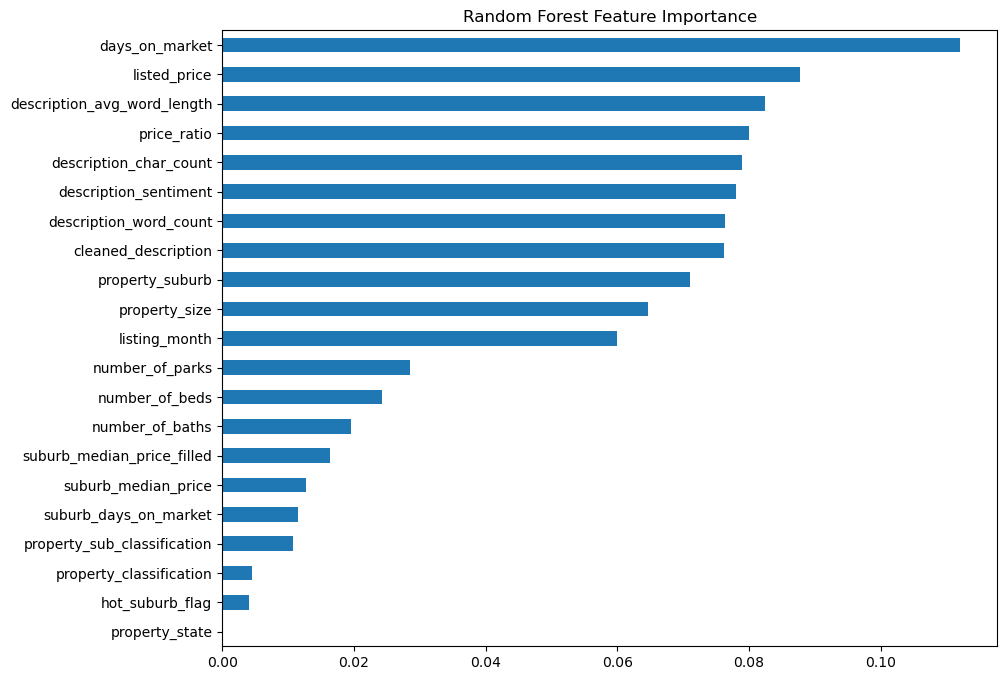

Random Forest ROC-AUC: 0.902


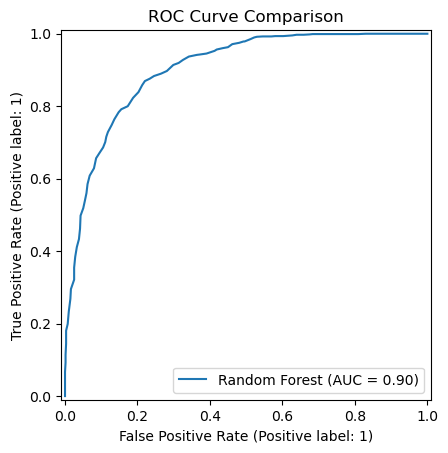

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}

=== Tuned Random Forest Report ===
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       676
           1       0.81      0.79      0.80      1080

    accuracy                           0.75      1756
   macro avg       0.74      0.74      0.74      1756
weighted avg       0.75      0.75      0.75      1756

Confusion Matrix:
[[471 205]
 [229 851]]
Cross-validated F1 scores: [0.81301939 0.81058496 0.78643579 0.81476323 0.80642907]
Mean F1 score: 0.806 ± 0.010
Tuned Random Forest ROC-AUC: 0.823


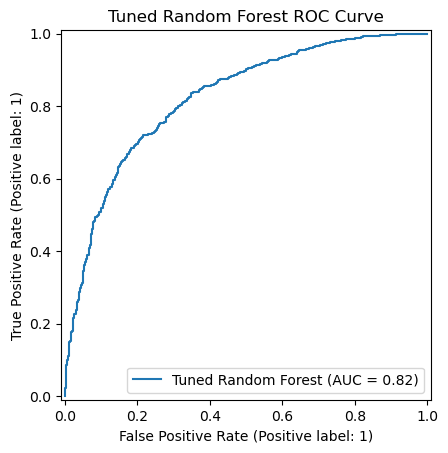

In [149]:
df_filtered['price_outcome_binary'] = df_filtered['price_outcome'].apply(lambda x: 1 if x == 'Higher' else 0)

# Specify columns to drop (including date and unnecessary text columns)
drop_cols = ['price_outcome', 'price_outcome_binary', 'property_address', 'listing_description', 'listed_date']
X = df_filtered.drop(columns=drop_cols)
y = df_filtered['price_outcome_binary']

# Apply label encoding to categorical columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Confirm there are no datetime columns remaining
print("✅ X data types after cleanup:")
print(X.dtypes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build Random Forest (basic version)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("=== Random Forest Report ===")
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

# Plot feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Random Forest Feature Importance')
plt.show()

# Plot ROC-AUC curve
rf_probs = rf.predict_proba(X_test)[:, 1]

print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, rf_probs):.3f}")

RocCurveDisplay.from_estimator(rf, X_test, y_test, name='Random Forest')
plt.title('ROC Curve Comparison')
plt.show()

# Updated parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300],          # Increase number of trees
    'max_depth': [5, 10],                # Limit tree depth to avoid overfitting
    'min_samples_split': [5, 10],        # Increase split threshold to make trees more conservative
    'max_features': ['sqrt'],            # Fixed proportion of features
    'class_weight': ['balanced']         # Automatically balance class weights
}

# GridSearchCV with parallel jobs
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

# Execute GridSearch
grid_search.fit(X_train, y_train)

# Print best parameters
print("✅ Best Parameters:", grid_search.best_params_)

# Use the best estimator to predict
best_rf = grid_search.best_estimator_
best_rf_preds = best_rf.predict(X_test)

print("\n=== Tuned Random Forest Report ===")
print(classification_report(y_test, best_rf_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, best_rf_preds))

# Check cross-validation scores for stability
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1', n_jobs=-1)
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Plot ROC curve
best_rf_probs = best_rf.predict_proba(X_test)[:, 1]
print(f"Tuned Random Forest ROC-AUC: {roc_auc_score(y_test, best_rf_probs):.3f}")
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, name='Tuned Random Forest')
plt.title('Tuned Random Forest ROC Curve')
plt.show()



# Conclusions & recommendations

On the one hand, the Random Forest model shows well-performed results and identifies main features well, such as price ratio and listing month. On the other hand, there is minimal impact from descriptions, as shown by sentiment scores. Property agencies should put more effort into pricing strategies, which link to market medians and seasonal listing timing (May–September), to increase profit. I recommend collecting rich neighborhood and buyer data to expand future models and better capture a more realistic market.